# Modeling Stock Returns

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
psei = pd.read_csv('Data2.csv', index_col=1, parse_dates=True)
psei = psei.iloc[:, 1:-1]
psei.head()

,Open,High,Low,Close
Date/Time,,,,
1958-01-31,3.06,3.06,3.06,3.06
1958-02-28,2.92,2.92,2.92,2.92
1958-03-31,3.15,3.15,3.15,3.15
1958-04-30,3.45,3.45,3.45,3.45
1958-05-31,3.56,3.56,3.56,3.56


In [8]:
psei['LogReturn'] = np.log(psei['Close']) - np.log(psei['Close'].shift(1))
psei.head()

,Open,High,Low,Close,LogReturn
Date/Time,,,,,
1958-01-31,3.06,3.06,3.06,3.06,NaN
1958-02-28,2.92,2.92,2.92,2.92,-0.046831
1958-03-31,3.15,3.15,3.15,3.15,0.075819
1958-04-30,3.45,3.45,3.45,3.45,0.090972
1958-05-31,3.56,3.56,3.56,3.56,0.031386


In [9]:
psei_2014 = psei['2014-01-01':]
psei_2014.head()

,Open,High,Low,Close,LogReturn
Date/Time,,,,,
2014-01-02,5923.7202,5984.2598,5923.7202,5984.2598,0.015906
2014-01-03,5971.3599,5971.3599,5903.7700,5947.9302,-0.006089
2014-01-06,5950.3901,5992.9800,5932.5098,5985.8101,0.006348
2014-01-07,5986.1802,5991.9302,5946.7202,5947.4399,-0.006431
2014-01-08,5948.2998,5995.0698,5942.6802,5986.4800,0.006543


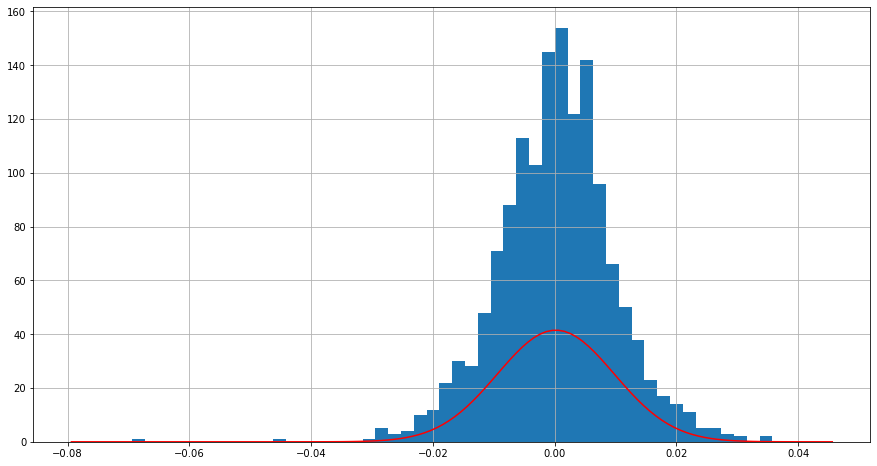

In [16]:
mu = psei_2014['LogReturn'].mean()
sigma = psei_2014['LogReturn'].std(ddof=1)

density = pd.DataFrame()
density['x'] = np.arange(psei_2014['LogReturn'].min() - 0.01,
                        psei_2014['LogReturn'].max() + 0.01,
                        0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

psei_2014['LogReturn'].hist(bins=50, figsize=(15, 8))
plt.plot(density['x'], density['pdf'], color='red');

# Compute probs

In [28]:
print(f'Probability of a 5% drop: {norm.cdf(-0.05, mu, sigma)}')
print(f'Probability of a 10% drop: {norm.cdf(-0.1, mu, sigma)}')

Probability of a 5% drop: 8.800491578561898e-08
Probability of a 10% drop: 9.435772889396671e-26


In [23]:
year_mu = mu * 220
year_sigma = sigma * np.sqrt(220)
print(f'Probability of a 20% drop in a year: {norm.cdf(-0.2, year_mu, year_sigma)}')
print(f'Probability of a 40% drop in a year: {norm.cdf(-0.4, year_mu, year_sigma)}')

Probability of a 20% drop in a year: 0.04444052550908148
Probability of a 40% drop in a year: 0.0009531429701294485


# VAR

In [31]:
print(f'Single day 5% VAR: {norm.ppf(0.05, mu, sigma)}')
print(f'95% quantile: {norm.ppf(0.95, mu, sigma)}')

Single day 5% VAR: -0.015613772832240705
95% quantile: 0.016000186069839134


In [32]:
print(f'25% quantile: {norm.ppf(0.25, mu, sigma)}')
print(f'75% quantile: {norm.ppf(0.75, mu, sigma)}')

25% quantile: -0.006288613676084114
75% quantile: 0.006675026913682549
